# Implementing LeNet Architecture using PyTorch

- we will be creating a LeNet CNN achitecture in PyTorch
- we will use custom_dataset and pizza_steak_sushi

LeNet is the canonical “starter” CNN. Its architecture is compact, efficient, and built around a simple principle: alternate convolution + subsampling blocks, then finish with fully-connected layers. Despite its age, it captures the core design pattern of modern CNNs.

![LeNet Architecture](https://github.com/codewizard-2004/PyTorch-Image-Recognition/blob/master/images/lener_arch.png?raw=1)

<h2>Architecture of LeNet </h2>

* Input size: 32 x 32
* C1 - Convolution Layer:
    - Filters: 6
    - Kernel: 5 × 5
    - Stride: 1
    - Padding: 0
    - Output size: 28 × 28 × 6

* S2 — Subsampling (Average Pooling)

    - Type: Average pooling
    - Kernel: 2 × 2
    - Stride: 2
    - Output size: 14 × 14 × 6
* S4 — Subsampling

    - Same as S2
    - Kernel: 2 × 2, stride 2
    - Output: 5 × 5 × 16

* C5 — Convolution (Fully Connected Convolution)

    - Filters: 120
    - Kernel: 5 × 5
    - Since the input is 5 × 5, this is effectively a fully connected layer.
    - Output: 1 × 1 × 120

* F6 — Fully Connected

    - Neurons: 84
    - Activation: tanh

* Output Layer

In [21]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.9.0+cu126
True
12.6
cuda


<h2>Loading a custom Dataset with 3 classes (pizza, steak, sushi) </h2>


In [2]:
!wget -O foodvision-mini.zip "https://github.com/codewizard-2004/PyTorch-Image-Recognition/raw/refs/heads/master/data/pizza_steak_sushi.zip"

--2025-12-06 04:09:35--  https://github.com/codewizard-2004/PyTorch-Image-Recognition/raw/refs/heads/master/data/pizza_steak_sushi.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/data/pizza_steak_sushi.zip [following]
--2025-12-06 04:09:36--  https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/data/pizza_steak_sushi.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63597725 (61M) [application/zip]
Saving to: ‘foodvision-mini.zip’

foodvision-mini.zip 100%[===================>]  60.65M   33

<h2> Unzipping the downloaded zip file </h2>

In [3]:
import zipfile

zip_path = "foodvision-mini.zip"
extract_path = "pizza_steak_sushi"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

## Fetching some utility functions

In [4]:
!mkdir -p utils
!wget -O utils/data_setup.py "https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/utils/data_setup.py"
!wget -O utils/display.py "https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/utils/display.py"
!wget -O utils/model_utils.py "https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/utils/model_utils.py"
!wget -O utils/process.py "https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/utils/process.py"

--2025-12-06 04:34:39--  https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/utils/data_setup.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5515 (5.4K) [text/plain]
Saving to: ‘utils/data_setup.py’

utils/data_setup.py 100%[===================>]   5.39K  --.-KB/s    in 0s      

2025-12-06 04:34:39 (67.2 MB/s) - ‘utils/data_setup.py’ saved [5515/5515]

--2025-12-06 04:34:39--  https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/utils/display.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP 

## Implementing the Transforms

In [5]:
from torchvision import transforms

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # Normalized to ImageNet mean/standard deviation

train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

print(f"Train Transform: {train_transform}")
print(f"Test Transform: {test_transform}")

Train Transform: Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Test Transform: Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Creating the DataSet

In [7]:
from torchvision.datasets import ImageFolder
from pathlib import Path

train_dir = Path("./pizza_steak_sushi/pizza_steak_sushi/train")
test_dir = Path("./pizza_steak_sushi/pizza_steak_sushi/test")

train_dataset = ImageFolder(
    root = train_dir,
    transform = train_transform

)

test_dataset = ImageFolder(
    root = test_dir,
    transform = test_transform
)

## Performing some data analysis

In [11]:
print(f"Number of images in train dataset: {len(train_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")
classes = train_dataset.classes
print(f"Number of classes: {len(classes)}")
image, label = train_dataset[0]
print(f"Image Shape: {image.shape} -> [color channels, height, width]")

Number of images in train dataset: 960
Number of images in test dataset: 240
Number of classes: 3
Image Shape: torch.Size([3, 64, 64]) -> [color channels, height, width]


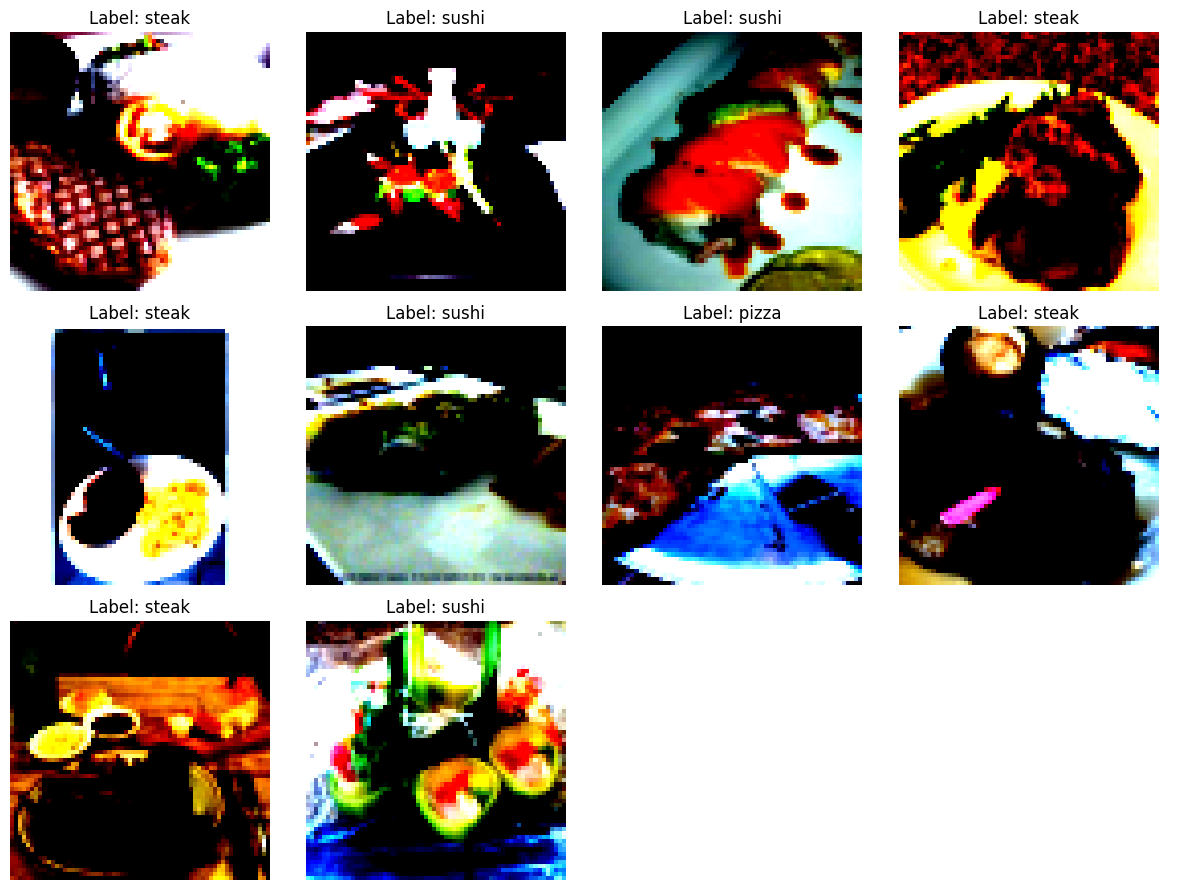

In [13]:
from utils.display import plot_random_images

plot_random_images(test_dataset, num = 10)

## Implementing DataLoader

In [27]:
import os

In [28]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count()
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size=BATCH_SIZE,
    shuffle = False,
    num_workers=os.cpu_count()
)

print(train_dataloader)
print(test_dataloader)

# Implementing LeNet Architecture

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet64(nn.Module):
    def __init__(self, in_channels: int = 3, num_classes: int = 3, pool_type: str = "avg"):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5)   # 64 -> 60
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)            # 30 -> 26
        self.bn2 = nn.BatchNorm2d(16)

        self.pool = nn.AvgPool2d(2, 2) if pool_type == "avg" else nn.MaxPool2d(2,2)

        # For 64x64 input, final spatial dims are 13x13 so flattened size = 16*13*13 = 2704
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [22]:
model_0 = LeNet64().to(device)

## LeNet64 Architecture Explanation

This `LeNet64` model is a variant of the classic LeNet-5 architecture, adapted for 64x64 pixel input images. It uses two convolutional layers followed by average pooling layers, and then three fully connected layers for classification. Below is a detailed breakdown of the image size transformation at each step:

**Input Image Size**: `(3, 64, 64)` (Channels, Height, Width)

### 1. First Convolutional Layer (`self.conv1`)
- **Layer**: `nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)`
- **Input Feature Map Size**: `(64, 64)`
- **Kernel Size (K)**: 5
- **Stride (S)**: 1 (default)
- **Padding (P)**: 0 (default)
- **Output Height (H')**: `((H - K + 2P) / S) + 1 = ((64 - 5 + 2*0) / 1) + 1 = 60`
- **Output Width (W')**: `((W - K + 2P) / S) + 1 = ((64 - 5 + 2*0) / 1) + 1 = 60`
- **Output Feature Map Size**: `(6, 60, 60)`

### 2. First Pooling Layer (`self.pool` after `conv1`)
- **Layer**: `nn.AvgPool2d(kernel_size=2, stride=2)` (assuming `pool_type='avg'`)
- **Input Feature Map Size**: `(60, 60)`
- **Kernel Size (K)**: 2
- **Stride (S)**: 2
- **Output Height (H')**: `((H - K) / S) + 1 = ((60 - 2) / 2) + 1 = 29 + 1 = 30`
- **Output Width (W')**: `((W - K) / S) + 1 = ((60 - 2) / 2) + 1 = 29 + 1 = 30`
- **Output Feature Map Size**: `(6, 30, 30)`

### 3. Second Convolutional Layer (`self.conv2`)
- **Layer**: `nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)`
- **Input Feature Map Size**: `(30, 30)`
- **Kernel Size (K)**: 5
- **Stride (S)**: 1 (default)
- **Padding (P)**: 0 (default)
- **Output Height (H')**: `((H - K + 2P) / S) + 1 = ((30 - 5 + 2*0) / 1) + 1 = 26`
- **Output Width (W')**: `((W - K + 2P) / S) + 1 = ((30 - 5 + 2*0) / 1) + 1 = 26`
- **Output Feature Map Size**: `(16, 26, 26)`

### 4. Second Pooling Layer (`self.pool` after `conv2`)
- **Layer**: `nn.AvgPool2d(kernel_size=2, stride=2)`
- **Input Feature Map Size**: `(26, 26)`
- **Kernel Size (K)**: 2
- **Stride (S)**: 2
- **Output Height (H')**: `((H - K) / S) + 1 = ((26 - 2) / 2) + 1 = 12 + 1 = 13`
- **Output Width (W')**: `((W - K) / S) + 1 = ((26 - 2) / 2) + 1 = 12 + 1 = 13`
- **Output Feature Map Size**: `(16, 13, 13)`

### 5. Flatten Layer
- **Input Feature Map Size**: `(16, 13, 13)`
- **Output Flattened Size**: `16 * 13 * 13 = 2704`
- This flattened vector then serves as the input to the fully connected layers.

### 6. Fully Connected Layers
- `fc1`: `nn.Linear(2704, 120)`
- `fc2`: `nn.Linear(120, 84)`
- `fc3`: `nn.Linear(84, num_classes)` (where `num_classes` is 3 for pizza, steak, sushi)

This step-by-step transformation reduces the spatial dimensions of the input image while increasing the number of feature channels, eventually flattening the features for classification by the fully connected layers.

In [23]:
try:
  from torchinfo import summary
except:
  print("Installing torchinfo")
  !pip install torchinfo
  from torchinfo import summary

summary(model_0)

Layer (type:depth-idx)                   Param #
LeNet64                                  --
├─Conv2d: 1-1                            456
├─BatchNorm2d: 1-2                       12
├─Conv2d: 1-3                            2,416
├─BatchNorm2d: 1-4                       32
├─AvgPool2d: 1-5                         --
├─Linear: 1-6                            324,600
├─Linear: 1-7                            10,164
├─Linear: 1-8                            255
Total params: 337,935
Trainable params: 337,935
Non-trainable params: 0

## Creating the loss function and optimizer

In [37]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params = model_0.parameters(),
    lr = 0.01
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=5,
    factor=0.1
)

In [38]:
from utils.process import run_train_test

result = run_train_test(
    model = model_0,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    device = torch.device(device),
    epochs = 30,
    scheduler = scheduler
)

starting....


  0%|          | 0/30 [00:00<?, ?it/s]

[] Allocated: 19.88 MB | Reserved: 66.00 MB
Epoch:0	Train Loss:2.1936	Train Acc:0.4313	Test Loss:1.0486	Test Acc:0.4062
[] Allocated: 22.46 MB | Reserved: 66.00 MB
Epoch:1	Train Loss:0.9284	Train Acc:0.5542	Test Loss:0.9632	Test Acc:0.5000
[] Allocated: 22.46 MB | Reserved: 66.00 MB
Epoch:2	Train Loss:0.8944	Train Acc:0.5740	Test Loss:0.9735	Test Acc:0.5195
[] Allocated: 22.46 MB | Reserved: 66.00 MB
Epoch:3	Train Loss:0.8534	Train Acc:0.6198	Test Loss:1.1794	Test Acc:0.4766
[] Allocated: 22.46 MB | Reserved: 66.00 MB
Epoch:4	Train Loss:0.8489	Train Acc:0.6177	Test Loss:0.9388	Test Acc:0.5430
[] Allocated: 22.46 MB | Reserved: 66.00 MB
Epoch:5	Train Loss:0.8387	Train Acc:0.6281	Test Loss:0.8909	Test Acc:0.5547
[] Allocated: 22.46 MB | Reserved: 66.00 MB
Epoch:6	Train Loss:0.7975	Train Acc:0.6458	Test Loss:1.0559	Test Acc:0.5430
[] Allocated: 22.46 MB | Reserved: 66.00 MB
Epoch:7	Train Loss:0.8011	Train Acc:0.6438	Test Loss:0.9196	Test Acc:0.5664
[] Allocated: 22.46 MB | Reserved: 66.00

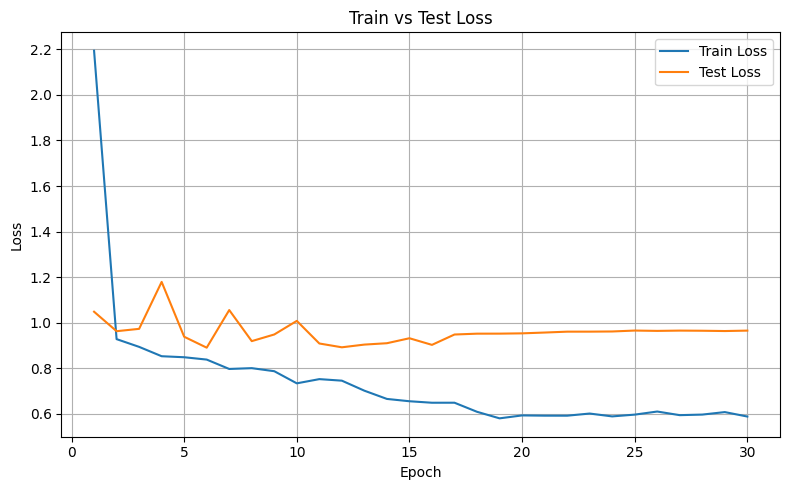

{'train_loss': [2.1935783489296834, 0.9283847709496816, 0.8944117069244385, 0.8533745427926381, 0.848918370405833, 0.8386669158935547, 0.7974951942761739, 0.8010745426019033, 0.7876486778259277, 0.7344383696715037, 0.752917664249738, 0.7461718519528707, 0.7021827260653178, 0.6660589655240376, 0.6558804333209991, 0.6493332237005234, 0.6494281391302744, 0.6096095283826192, 0.5808948367834091, 0.5937174687782923, 0.5926245431105296, 0.5924985855817795, 0.6019269903500875, 0.5894075254599254, 0.5971980214118957, 0.610757976770401, 0.5948528707027435, 0.5973625391721725, 0.6083040604988734, 0.5888199945290883], 'train_acc': [0.43125, 0.5541666666666667, 0.5739583333333333, 0.6197916666666666, 0.6177083333333333, 0.628125, 0.6458333333333334, 0.64375, 0.659375, 0.6833333333333333, 0.66875, 0.6864583333333333, 0.7114583333333333, 0.7177083333333333, 0.7302083333333333, 0.721875, 0.7395833333333334, 0.7604166666666666, 0.7625, 0.7614583333333333, 0.7666666666666667, 0.7635416666666667, 0.75625

In [41]:
from utils.display import plot_train_vs_test_loss
plot_train_vs_test_loss(result)
print(result)


In [44]:
def get_model_final_result(result: dict[str ,float])->dict[str, float]:
    model_result = {}

    for i in result:
        if i == "time":
            model_result[i] = result[i]
        else:
            model_result[i] = result[i][-1]

    return model_result

model_0_final_results =  get_model_final_result(result)
model_0_final_results

{'train_loss': 0.5888199945290883,
 'train_acc': 0.7614583333333333,
 'test_loss': 0.9657484367489815,
 'test_acc': 0.55859375,
 'time': 104.71995496749878}

## Making some predictions with the model

In [51]:
from utils.model_utils import make_prediction

correct = 0
wrong = 0
inf_time = 0
for data in test_dataset:
    prediction, conf, inf = make_prediction(model_0, data, classes, torch.device(device))

    if prediction == classes[data[1]]:
        correct += 1
    else:
        wrong += 1

    inf_time +=inf

print(f"correct: {correct}")
print(f"Incorrect: {wrong}")
print(f"Correct %: {(correct/len(test_dataset))*100: .2f}")
print(f"average inference time: {inf_time/(correct+wrong): .2f} s")

correct: 136
Incorrect: 104
Correct %:  56.67
average inference time:  0.72 s


## Saving the Model

In [54]:
!mkdir -p models

In [55]:
dest = Path("./models")
dest.exists()

True

In [57]:
from utils.model_utils import save_model

metadata = {
    "arch": "LeNet64",
    "desc": "LeNet architecture with trivial transform augementation for 64x64 images.\nIt can predict three classes (pizza, steak, sushi)",
    "train_acc": round(result["train_acc"][-1]*100, 2),
    "training_images": len(train_dataset),
    "parameters":sum(p.numel() for p in model_0.parameters())
}

save_model(
    model = model_0,
    metadata = metadata,
    name = "LeNet64",
    loc = dest,
    device = torch.device(device)
)

model saved at models/LeNet64.pt


* Save the entire model

In [58]:
torch.save(model_0,dest, dest/"LeNet64_full.pth")

* saving just the state_dict

In [63]:
torch.save(model_0.state_dict(), dest / "LeNet64_state_dict.pth")